# 13 Models With Memory

## Imports, loadings and functions

In [1]:
import numpy as np

from scipy import stats

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import pandas as pd

import networkx as nx
# from causalgraphicalmodels import CausalGraphicalModel

import arviz as az
# ArviZ ships with style sheets!
# https://python.arviz.org/en/stable/examples/styles.html#example-styles
az.style.use("arviz-darkgrid")

import xarray as xr

import stan
import nest_asyncio

plt.style.use('default')
plt.rcParams['axes.facecolor'] = 'lightgray'

# To DAG's
import daft
# from causalgraphicalmodels import CausalGraphicalModel  # Just work in < python3.9 

In [2]:
# Add fonts to matplotlib to run xkcd

from matplotlib import font_manager

font_dirs = ["fonts/"]  # The path to the custom font file.
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

In [3]:
# To make plots like drawing 
# plt.xkcd()

In [4]:
# To running the stan in jupyter notebook
nest_asyncio.apply()

In [5]:
# Utils functions

def logit(p):
    return np.log(p) - np.log(1 - p)

def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))

## 13.1 Example: Multilevel tadpoles

### R Code 13.1

In [6]:
df = pd.read_csv('./data/reedfrogs.csv', sep=";")
df['tank'] = df.index.to_list()
df['tank'] += 1  # index start from 1 like Stan works
df

,density,pred,size,surv,propsurv,tank
0,10,no,big,9,0.900000,1
1,10,no,big,10,1.000000,2
2,10,no,big,7,0.700000,3
3,10,no,big,10,1.000000,4
4,10,no,small,9,0.900000,5
5,10,no,small,9,0.900000,6
6,10,no,small,10,1.000000,7
7,10,no,small,9,0.900000,8
8,10,pred,big,4,0.400000,9
9,10,pred,big,9,0.900000,10


In [7]:
df.describe()

,density,surv,propsurv,tank
count,48.000000,48.000000,48.000000,48.00
mean,23.333333,16.312500,0.721607,24.50
std,10.382746,9.884775,0.266416,14.00
min,10.000000,4.000000,0.114286,1.00
25%,10.000000,9.000000,0.496429,12.75
50%,25.000000,12.500000,0.885714,24.50
75%,35.000000,23.000000,0.920000,36.25
max,35.000000,35.000000,1.000000,48.00


### R Code 13.2

$$ S_i \sim Binomial(N_i, p_i) $$

$$ logit(p_i) = \alpha_{TANK[i]} $$

$$ \alpha_j \sim Normal(0, 1.5), \mbox{ for } j \in \{1, 48\}$$

In [8]:
model = """
    data {
        int qty;
        array[qty] int N;  // Total quantities that have tadpoles in tank
        array[qty] int survival;  // How many tadpoles survival
        array[qty] int tank;  // Tank index
    }
    
    parameters {
        vector[qty] alpha;
    }
    
    model {
        vector[qty] p;
        
        alpha ~ normal(0, 1.5);
        
        for (i in 1:qty){
            p[i] = alpha[ tank[i] ];
            p[i] = inv_logit(alpha[i]);
        }
        
        survival ~ binomial(N, p);
        
    }
"""

dat_list = {
    'qty': len(df),
    'tank': df['tank'].to_list(),
    'survival': df['surv'].to_list(),
    'N': df['density'].to_list()
}


posteriori = stan.build(model, data=dat_list)
samples = posteriori.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 4.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.43 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.45 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.57 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.4 seconds.
  Adjust your expectations accordingly!


In [9]:
model_13_1 = az.from_pystan(
    posterior=samples,
    posterior_model=posteriori,
    observed_data=dat_list.keys()
)

In [10]:
az.summary(model_13_1, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],1.712,0.753,0.491,2.818,0.011,0.009,5434.0,2697.0,1.0
alpha[1],2.424,0.913,0.944,3.853,0.013,0.010,5589.0,2907.0,1.0
alpha[2],0.761,0.648,-0.311,1.751,0.009,0.009,5590.0,2590.0,1.0
alpha[3],2.408,0.910,0.950,3.796,0.014,0.011,4742.0,2453.0,1.0
alpha[4],1.727,0.762,0.522,2.960,0.010,0.009,5727.0,2765.0,1.0
alpha[5],1.708,0.772,0.494,2.956,0.010,0.009,5726.0,3082.0,1.0
alpha[6],2.397,0.879,1.025,3.768,0.014,0.010,4321.0,2894.0,1.0
alpha[7],1.719,0.774,0.461,2.888,0.010,0.008,6783.0,2837.0,1.0
alpha[8],-0.366,0.620,-1.333,0.641,0.008,0.009,6063.0,2816.0,1.0
alpha[9],1.716,0.787,0.457,2.925,0.012,0.010,4944.0,2674.0,1.0


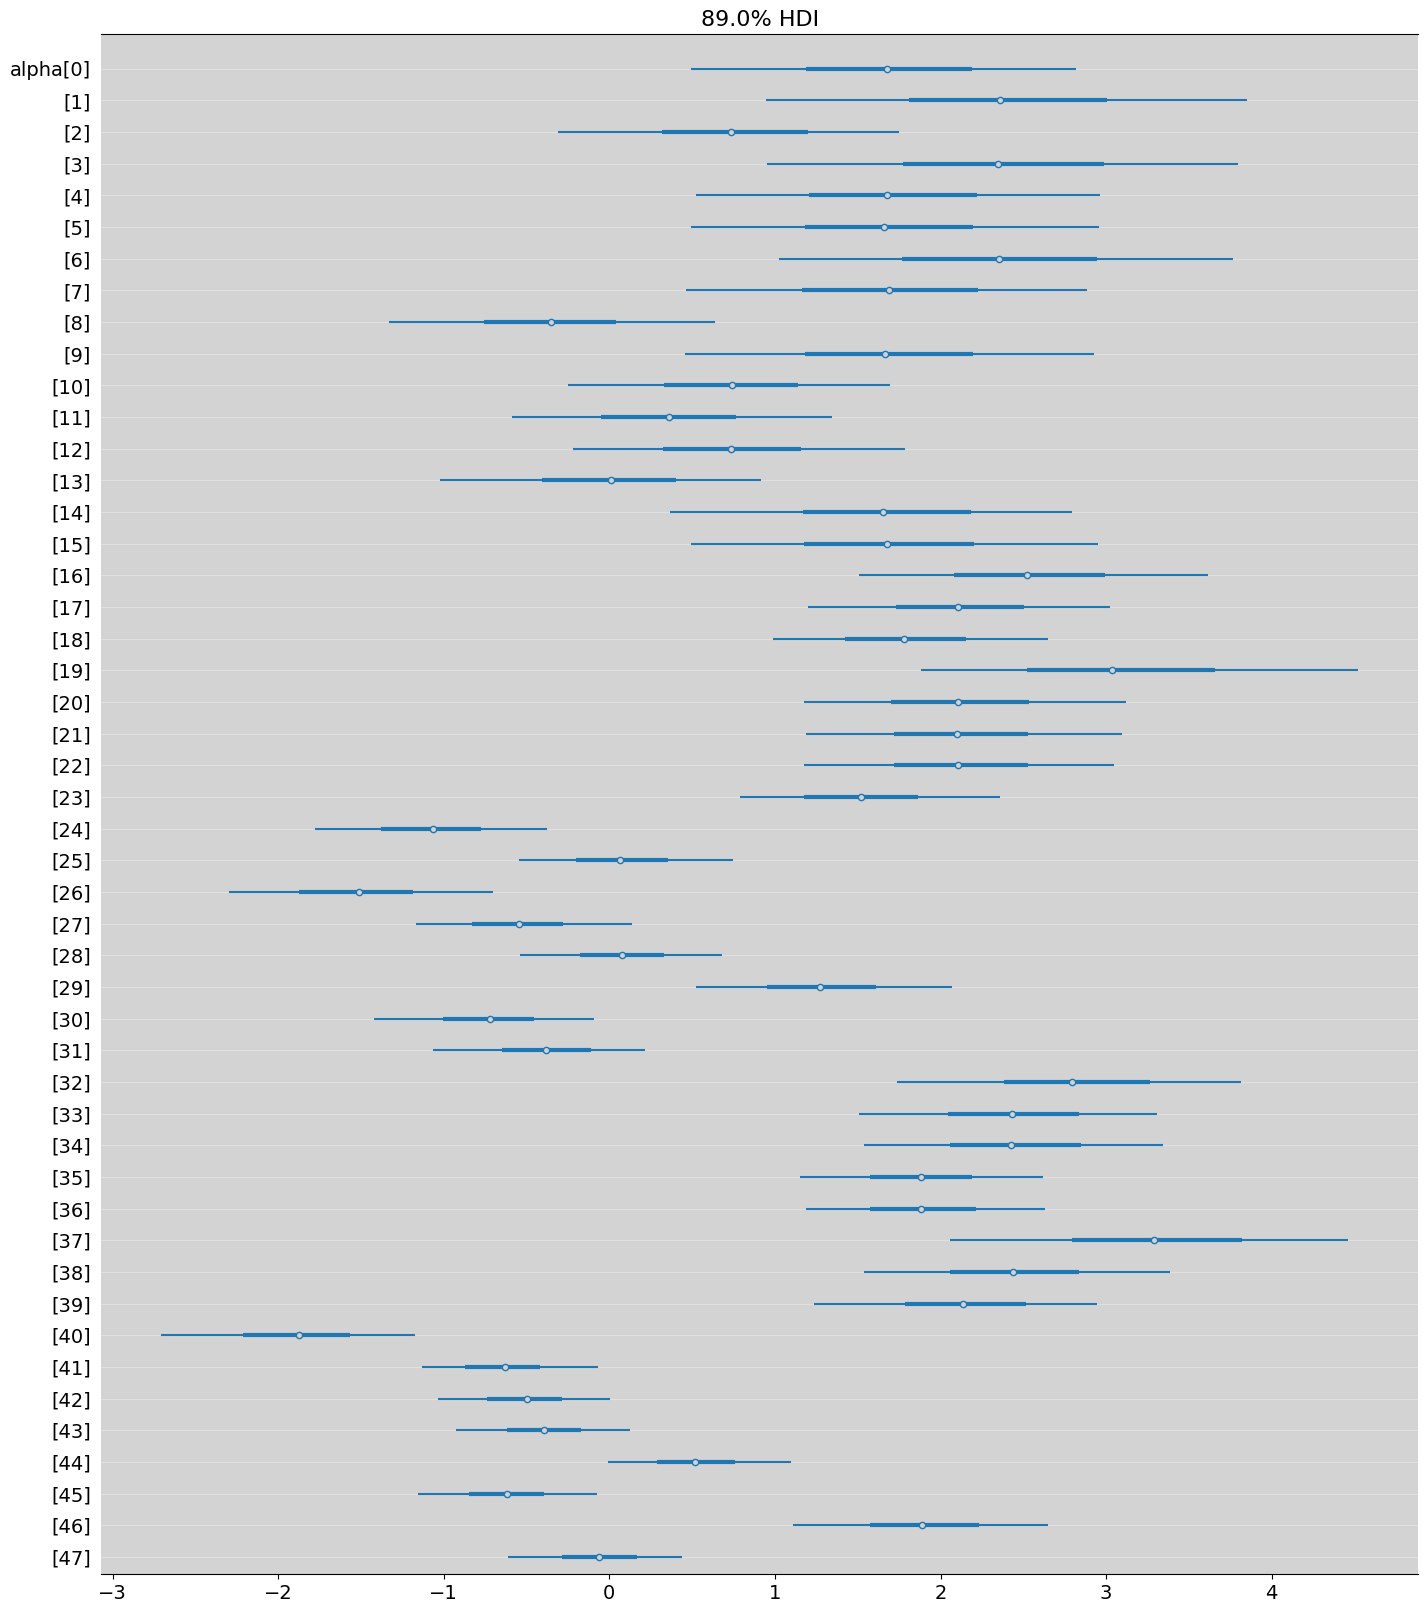

In [11]:
az.plot_forest(model_13_1, hdi_prob=0.89, combined=True, figsize=(17, 20))

plt.grid(axis='y', c='white', alpha=0.3)
plt.show()

### R Code 13.3

#### Multilevel model Tadpole

$$ S_i \sim Binomial(N_i, p_i) $$

$$ logit(p_i) = \alpha_{TANK[i]} $$

$$ \alpha[j] \sim Normal(\bar{\alpha}, \sigma) \mbox{ - [Adaptative prior]} $$

$$ \bar{\alpha} \sim Normal(0, 1.5) \mbox{ - [prior to average tank]} $$

$$ \sigma \sim Exponential(1) \mbox{ - [prior for standard deviation of tanks]} $$

In [12]:
model = """
    data {
        int qty;
        array[qty] int N;
        array[qty] int survival;
        array[qty] int tank;
    }
    
    parameters {
        vector[qty] alpha;
        real bar_alpha;
        real<lower=0> sigma;
    }
    
    model {
        vector[qty] p;
        
        alpha ~ normal(bar_alpha, sigma);
        
        bar_alpha ~ normal(0, 1.5);
        sigma ~ exponential(1);
        
        for (i in 1:qty){
            p[i] = alpha[ tank[i] ];
            p[i] = inv_logit(p[i]);
        }
    
        survival ~ binomial(N, p);
    }
"""


dat_list = {
    'qty': len(df),
    'tank': df['tank'].to_list(),
    'survival': df['surv'].to_list(),
    'N': df['density'].to_list()
}


posteriori = stan.build(model, data=dat_list)
samples = posteriori.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 3.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.39 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.33 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.4 seconds.
  Adjust your expectations accordingly!


In [13]:
model_13_2 = az.from_pystan(
    posterior=samples,
    posterior_model=posteriori,
    observed_data=dat_list.keys(),
)

In [14]:
az.summary(model_13_2, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],2.142,0.908,0.711,3.487,0.013,0.011,5280.0,2789.0,1.0
alpha[1],3.095,1.106,1.382,4.792,0.018,0.014,4312.0,2318.0,1.0
alpha[2],1.000,0.679,-0.028,2.111,0.010,0.009,4911.0,2825.0,1.0
alpha[3],3.105,1.129,1.224,4.780,0.016,0.013,5605.0,2415.0,1.0
alpha[4],2.151,0.881,0.774,3.501,0.013,0.011,4748.0,2494.0,1.0
alpha[5],2.129,0.867,0.848,3.562,0.013,0.011,5689.0,2332.0,1.0
alpha[6],3.085,1.113,1.383,4.817,0.017,0.014,4769.0,2672.0,1.0
alpha[7],2.147,0.873,0.901,3.613,0.013,0.011,5110.0,2577.0,1.0
alpha[8],-0.181,0.610,-1.221,0.738,0.008,0.009,5794.0,2944.0,1.0
alpha[9],2.147,0.887,0.692,3.453,0.014,0.012,4458.0,2359.0,1.0


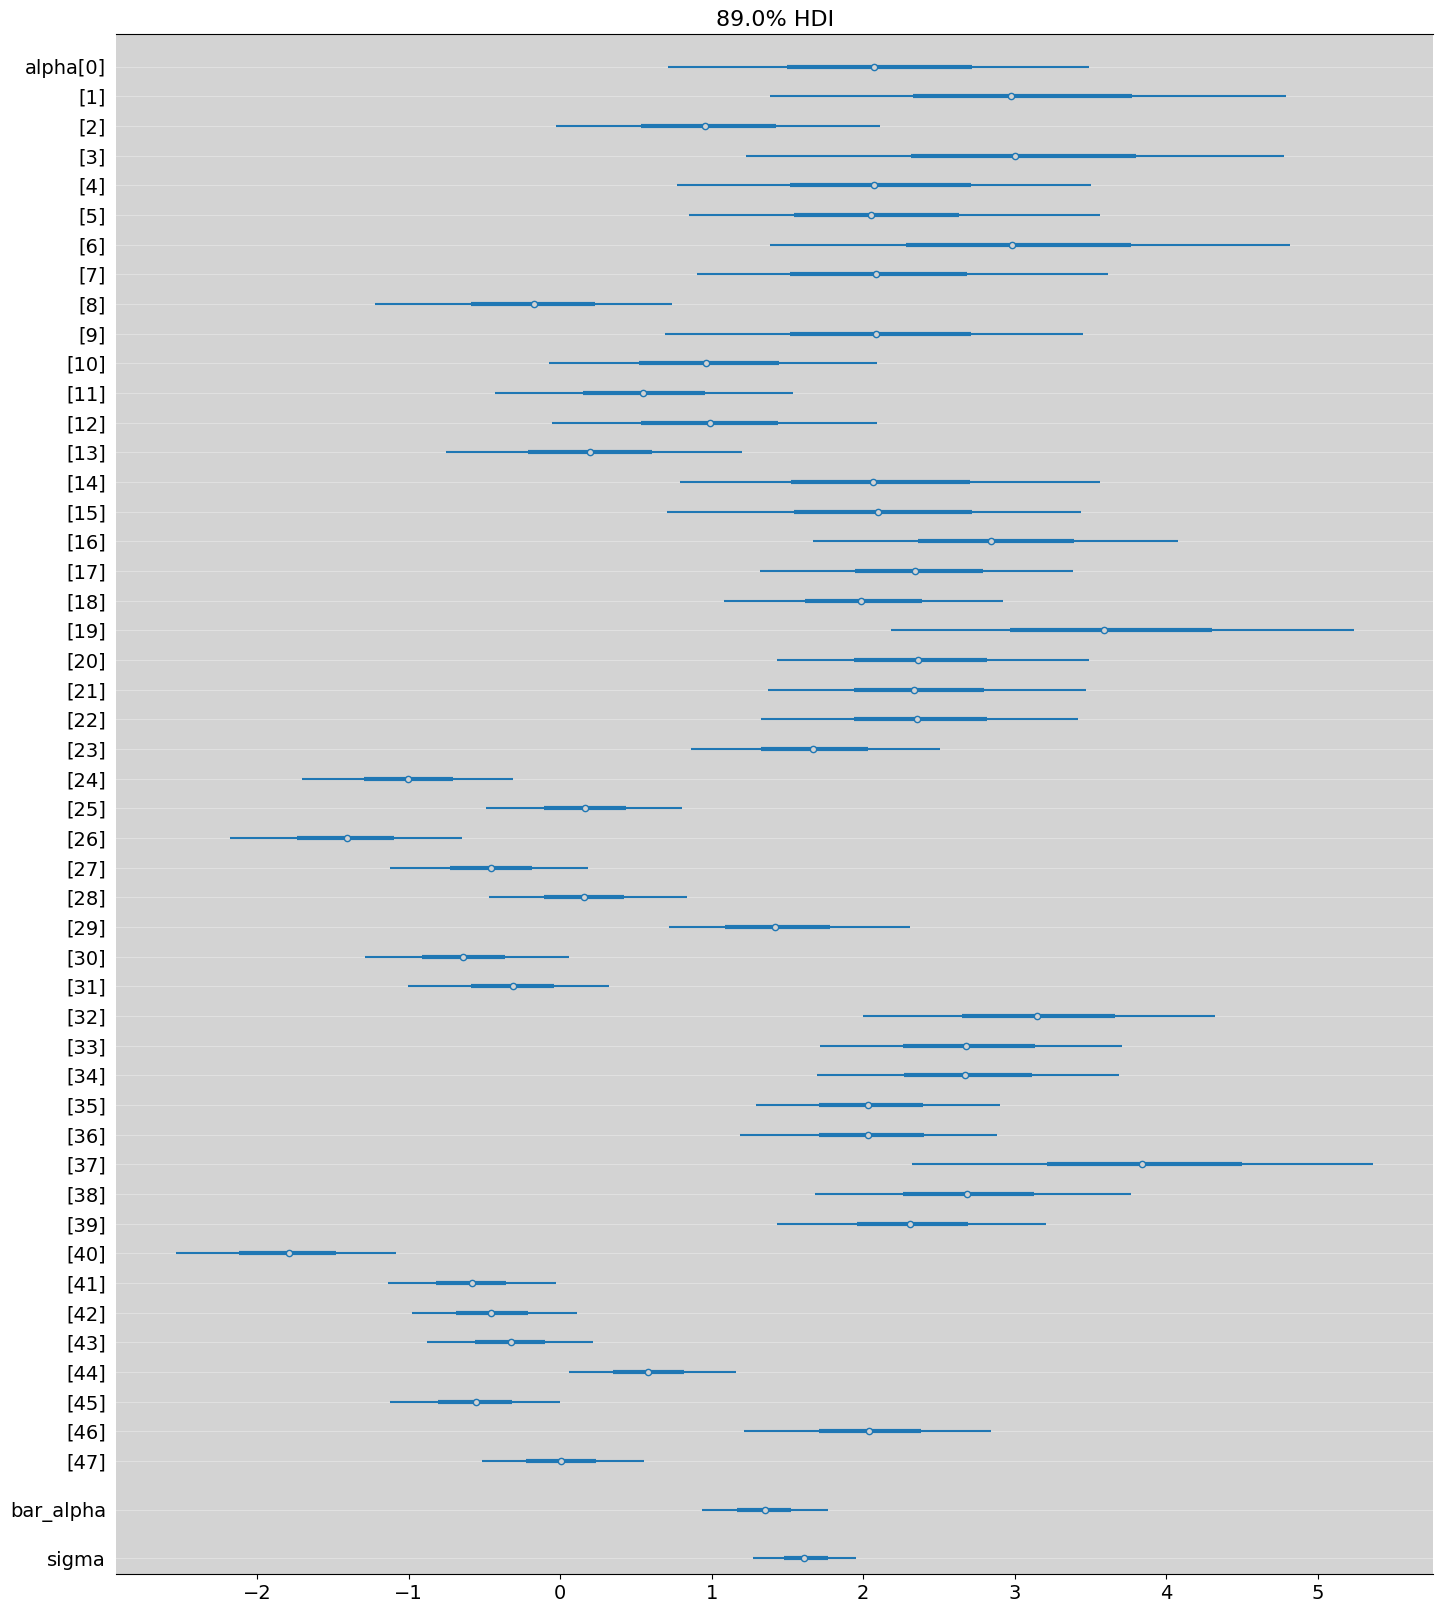

In [15]:
az.plot_forest(model_13_2, hdi_prob=0.89, combined=True, figsize=(17, 20))

plt.grid(axis='y', color='white', alpha=0.3)
plt.show()

### R Code 13.4

In [16]:
# az.compare(model_13_1, model_13_2)

### R Code 13.5

In [17]:
means = [ model_13_2.posterior.alpha.sel(alpha_dim_0=(i-1)).values.flatten().mean() for i in df.tank ]
means = inv_logit(means)

In [18]:
# My test, this is not originaly in book
means_13_1 = [ model_13_1.posterior.alpha.sel(alpha_dim_0=(i-1)).values.flatten().mean() for i in df.tank ]
means_13_1 = inv_logit(means_13_1)

In [19]:
bar_alpha_log = model_13_2.posterior.bar_alpha.values.flatten()
bar_alpha = inv_logit(bar_alpha_log)
bar_alpha_mean = bar_alpha.mean() 

sigma_log = model_13_2.posterior.sigma.values.flatten()
sigma = inv_logit(sigma_log)
sigma_mean = sigma.mean()

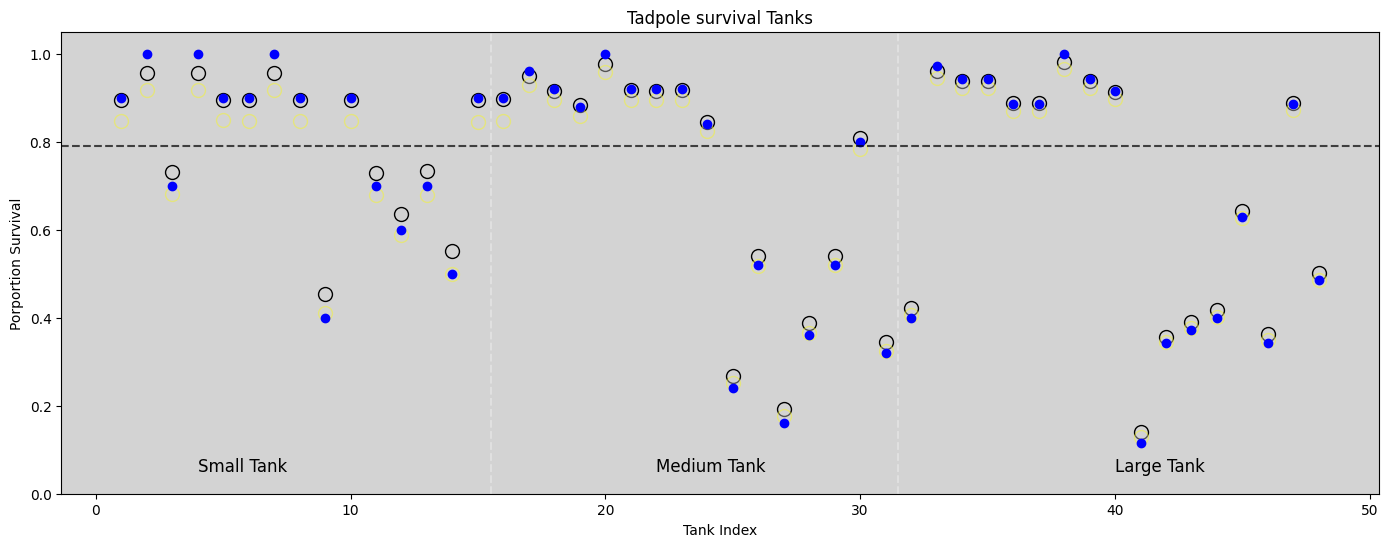

In [20]:
plt.figure(figsize=(17, 6))
plt.ylim = ([0, 1])

plt.scatter(df.tank, means, edgecolors='black', c='lightgray', s=100)
plt.scatter(df.tank, means_13_1, edgecolors='yellow', c='lightgray', s=100, alpha=0.4)
plt.scatter(df.tank, df.propsurv, c='blue')


plt.axvline(x=15.5, ls='--', color='white', alpha=0.3)
plt.axvline(x=31.5, ls='--', color='white', alpha=0.3)

plt.axhline(y=bar_alpha_mean, ls='--', c='black', alpha=0.7)

plt.text(4, 0.05, 'Small Tank', size=12)
plt.text(22, 0.05, 'Medium Tank', size=12)
plt.text(40, 0.05, 'Large Tank', size=12)

plt.gca().set_ylim(0.0, 1.05)

plt.title('Tadpole survival Tanks')
plt.xlabel('Tank Index')
plt.ylabel('Porportion Survival')

plt.show()

- **Blue dot**: Proportion survival s_i/N_i

- **Black circle**: Multilevel model estimative

- **Light Yellow**: No-pooling estimative

### R Code 13.6

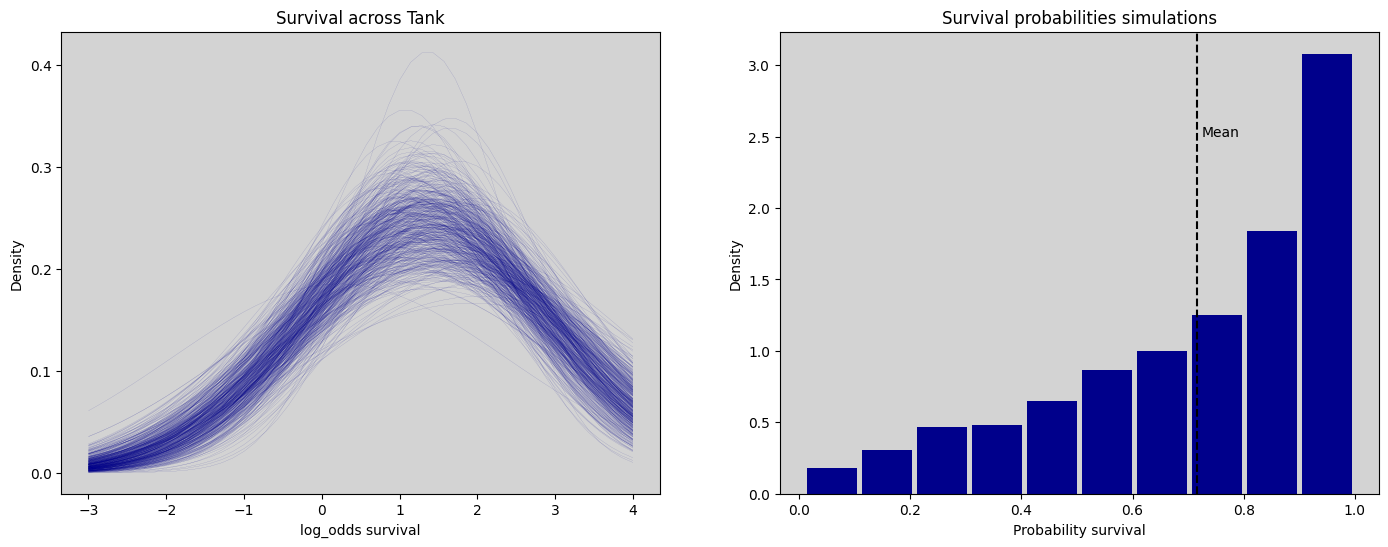

In [24]:
fig = plt.figure(figsize=(17, 6))
gs = GridSpec(1, 2)

x = np.linspace(-3, 4)

s_sampled = 500

ax1 = fig.add_subplot(gs[0, 0])
log_odds_survival = []
log_odds_sampled_index = np.random.choice(len(bar_alpha_log) ,size=s_sampled, replace=False)

for i in log_odds_sampled_index:
    log_odds_survival.append(stats.norm.pdf(x, bar_alpha_log[i], sigma_log[i]))

for i in range(s_sampled):
    ax1.plot(x, log_odds_survival[i], c='darkblue', linewidth=0.05)
ax1.set_title('Survival across Tank')
ax1.set_xlabel('log_odds survival')
ax1.set_ylabel('Density')
    

ax2 = fig.add_subplot(gs[0, 1])
samples_log = np.random.normal(bar_alpha_log, sigma_log)
ax2.hist(inv_logit(samples_log), rwidth=0.9, color='darkblue', density=True)
ax2.axvline(x=np.mean(inv_logit(samples_log)), c='black', ls='--')
ax2.text(np.mean(inv_logit(samples_log))+0.01, 2.5, 'Mean')

ax2.set_title('Survival probabilities simulations')
ax2.set_xlabel('Probability survival')
ax2.set_ylabel('Density')

plt.show()